<a href="https://colab.research.google.com/github/fundaylncii/NaturalLanguageProcessing/blob/main/NLPCaseStudy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width",200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [3]:
import nltk
nltk.download("stopwords")
sw = stopwords.words("english")

nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
df = pd.read_csv("/content/wiki_data.csv")
## Data boyutu büyük olduğu için ilk 2000 satır işlemlerde kullanılacak
df = df[:2000]

In [5]:
df.head()

,Unnamed: 0,text
0,1,Anovo\n\nAnovo (formerly A Novo) is a computer...
1,2,Battery indicator\n\nA battery indicator (also...
2,3,"Bob Pease\n\nRobert Allen Pease (August 22, 19..."
3,4,CAVNET\n\nCAVNET was a secure military forum w...
4,5,CLidar\n\nThe CLidar is a scientific instrumen...


In [6]:
df.shape

(2000, 2)

In [7]:
## Text Preprocessing İşlemleri için fonksiyon oluşturma

def clean(text):
  ## metinleri küçük harfe çevirme
  text = text.str.lower()

  ## metin içerisinden noktalama işaretlerinin kaldırılması
  text = text.str.replace("[^\w\s]", "",regex=True)

  ## metin içerisinden sayısal değerlerin kaldırılması
  text = text.str.replace("\d","",regex=True)

  return text

In [8]:
df["text"]  = clean(df["text"])

In [9]:
df["text"][:10]

,text
0,anovo\n\nanovo formerly a novo is a computer s...
1,battery indicator\n\na battery indicator also ...
2,bob pease\n\nrobert allen pease august â â ju...
3,cavnet\n\ncavnet was a secure military forum w...
4,clidar\n\nthe clidar is a scientific instrumen...
5,capacity loss\n\ncapacity loss or capacity fad...
6,carbon recycling international\n\ncarbon recyc...
7,chemical agent resistant coating\n\nchemical a...
8,claas cougar\n\nthe claas cougar is a selfprop...
9,conductive polymer\n\nconductive polymers or m...


In [10]:
## Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimeleri çıkaracak remove_stopwords fonksiyonunun oluşturulması:

def remove_stopwords(text, stopwordss):
  text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stopwordss))
  return text

In [11]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
df["text"] = remove_stopwords(df["text"],sw)

In [13]:
df["text"][:10]

,text
0,anovo anovo formerly novo computer services co...
1,battery indicator battery indicator also known...
2,bob pease robert allen pease august â â june a...
3,cavnet cavnet secure military forum became ope...
4,clidar clidar scientific instrument used measu...
5,capacity loss capacity loss capacity fading ph...
6,carbon recycling international carbon recyclin...
7,chemical agent resistant coating chemical agen...
8,claas cougar claas cougar selfpropelled mower ...
9,conductive polymer conductive polymers precise...


In [14]:
## metinlere rare words lerin çıkartılması :

## metindeki kelimelerin frekansları

tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["text", "count"]
tf.head()

drop = tf[tf["count"] < 1000]
drop[0:10]



df["text"] = df["text"].apply(lambda x: " ".join(x for x in str(x).split() if x not in drop))
df["text"][:10]


,text
0,anovo anovo formerly novo computer services co...
1,battery indicator battery indicator also known...
2,bob pease robert allen pease august â â june a...
3,cavnet cavnet secure military forum became ope...
4,clidar clidar scientific instrument used measu...
5,capacity loss capacity loss capacity fading ph...
6,carbon recycling international carbon recyclin...
7,chemical agent resistant coating chemical agen...
8,claas cougar claas cougar selfpropelled mower ...
9,conductive polymer conductive polymers precise...


In [15]:
## metinleri tokenize etmek:

nltk.download("punkt")
nltk.download("punkt_tab")

df["text"].apply(lambda x:TextBlob(x).words).head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text
0,"[anovo, anovo, formerly, novo, computer, servi..."
1,"[battery, indicator, battery, indicator, also,..."
2,"[bob, pease, robert, allen, pease, august, â, ..."
3,"[cavnet, cavnet, secure, military, forum, beca..."
4,"[clidar, clidar, scientific, instrument, used,..."


In [16]:
## metinlere LEMMATIZATION işlemi yapmak : köklerine ayırmak
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
df["text"] = df["text"].apply(lambda x: " ".join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))


In [18]:
df["text"][0:10]

,text
0,anovo anovo formerly novo computer service com...
1,battery indicator battery indicator also known...
2,bob pea robert allen pea august â â june analo...
3,cavnet cavnet secure military forum became ope...
4,clidar clidar scientific instrument used measu...
5,capacity loss capacity loss capacity fading ph...
6,carbon recycling international carbon recyclin...
7,chemical agent resistant coating chemical agen...
8,claas cougar claas cougar selfpropelled mower ...
9,conductive polymer conductive polymer precisel...


In [20]:
## tf dataframe ile metin frekansları hesaplanmıştı

tf.head()

,text,count
0,anovo,2.00
1,company,1688.00
2,score,97.00
3,news,148.00
4,awards,168.00


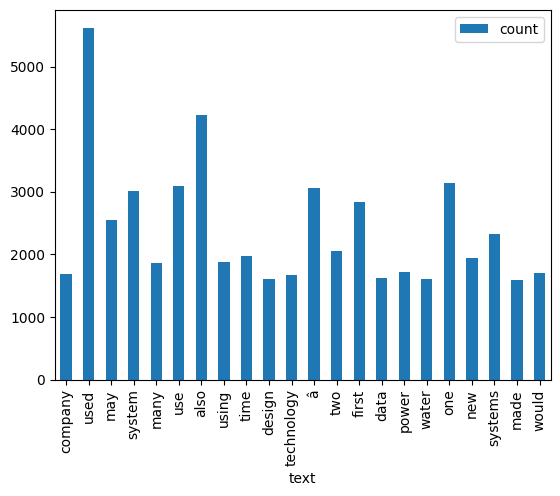

In [22]:
## barplot grafiğinin oluşturulması

tf[tf["count"] > 1500].plot.bar(x="text", y="count")
plt.show()

In [23]:
## WordCloud oluşturma:

## tüm kelimeler tek bir metin haline getirilir
text2 = " ".join(i for i in df.text)

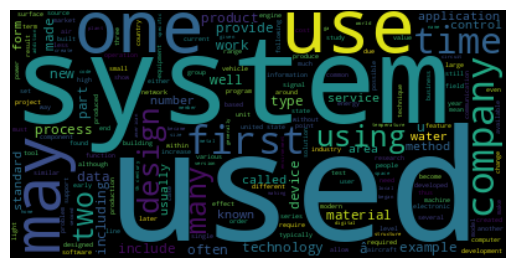

In [24]:
wc = WordCloud().generate_from_text(text2)
plt.imshow(wc, interpolation ="bilinear")
plt.axis("off")
plt.show()

In [28]:
## Tüm aşamaları tek bir fonksiyon haline getirmek: ek olark docstring oluşturma

df = pd.read_csv("/content/wiki_data.csv", index_col=0)


def wiki_process(text, Barplot = False, Worldcloud = False):
  """
  Textler üzerinde ön işleme yapar.

  :param text : Dataframdeki textlerin olduğu değişken
  :param Barplot : Barplot görselleştirme
  :param Worldcloud : Worldcloud görselleştirme
  :return : text

  Example:
  wiki_process(df["text"])

  """

  ## metinleri küçük harfe çevirme
  text = text.str.lower()

  ## metin içerisinden noktalama işaretlerinin kaldırılması
  text = text.str.replace("[^\w\s]", "",regex=True)

  ## metin içerisinden sayısal değerlerin kaldırılması
  text = text.str.replace("\d","",regex=True)

  ## stopwords
  sw = stopwords.words("english")
  text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

  ## rarewords
  tf = text.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["text", "count"]
  drop = tf[tf["count"] < 1000]
  text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in drop))

  ## tokinize
  text.apply(lambda x:TextBlob(x).words).head()

  ## lemmatization
  text = text.apply(lambda x: " ".join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))

  if Barplot:
    tf[tf["count"] > 1500].plot.bar(x="text", y="count")
    plt.show()

  if Worldcloud:
    text2 = " ".join(i for i in df.text)
    wc = WordCloud().generate_from_text(text2)
    plt.imshow(wc, interpolation ="bilinear")
    plt.axis("off")
    plt.show()

  return text


In [29]:
df = df[0:1000]
wiki_process(df["text"])

,text
1,anovo anovo formerly novo computer service com...
2,battery indicator battery indicator also known...
3,bob pea robert allen pea august â â june analo...
4,cavnet cavnet secure military forum became ope...
5,clidar clidar scientific instrument used measu...
...,...
996,coat rack coat rack coat stand hatstand item f...
997,computeraided maintenance computeraided mainte...
998,copperii azide copperii azide medium density e...
999,cosmetovigilance cosmetovigilance ongoing syst...


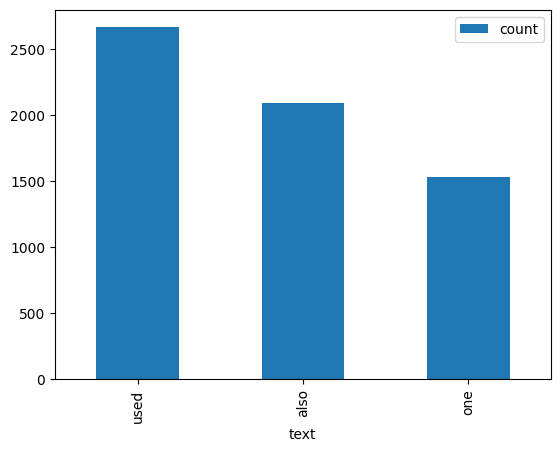

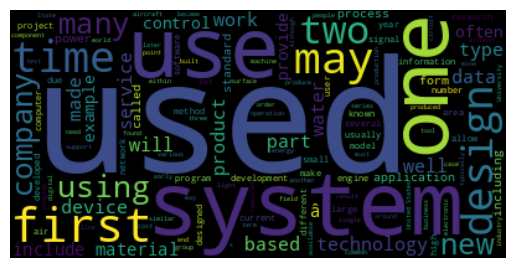

,text
1,anovo anovo formerly novo computer service com...
2,battery indicator battery indicator also known...
3,bob pea robert allen pea august â â june analo...
4,cavnet cavnet secure military forum became ope...
5,clidar clidar scientific instrument used measu...
...,...
996,coat rack coat rack coat stand hatstand item f...
997,computeraided maintenance computeraided mainte...
998,copperii azide copperii azide medium density e...
999,cosmetovigilance cosmetovigilance ongoing syst...


In [34]:
df = df[0:1000]
wiki_process(df["text"], Barplot=True, Worldcloud=True)